In [24]:
!pip install pulp
from pulp import LpMinimize, LpProblem, LpVariable, LpStatus, value, lpSum, LpStatusOptimal

# Strategic sourcing case study

# --- 1. EXPANDED DATA SET ---
suppliers = ['India', 'Germany', 'USA']
markets = ['Europe', 'Asia']
demand = {'Europe': 12000, 'Asia': 8000}  # Units
max_total_co2 = 15000  # Global limit in kg CO2

# 🎯 FIX: Define the total demand variable by summing the market demands
demande_totale = sum(demand.values())

# Cost and Sustainability Data (simplified matrices for quick code)
fixed_costs = {'India': 50000, 'Germany': 80000, 'USA': 60000}
var_costs = {'India': 4.0, 'Germany': 6.5, 'USA': 5.5} # Production Cost $/Unit
co2_per_unit = {'India': 1.2, 'Germany': 0.5, 'USA': 0.8} # Production CO2 kg/Unit

# Shipping Cost $/Unit (Supplier to Market)
shipping_cost = {
    ('India', 'Europe'): 1.5, ('India', 'Asia'): 0.8,
    ('Germany', 'Europe'): 0.5, ('Germany', 'Asia'): 2.0,
    ('USA', 'Europe'): 1.0, ('USA', 'Asia'): 2.5
}
# Capacity of each supplier
capacity = {'India': 15000, 'Germany': 10000, 'USA': 12000}

# --- 2. MODEL INITIALIZATION ---
model = LpProblem("Global_Strategic_Sourcing", LpMinimize)

# --- 3. DECISION VARIABLES (MILP) ---

# A. Production Flow (Continuous): Units sourced from supplier 'i' to market 'j'
x = LpVariable.dicts("Flow",
                     ((i, j) for i in suppliers for j in markets),
                     lowBound=0, cat='Continuous')

# B. Supplier Selection (Binary): 1 if supplier 'i' is used, 0 otherwise.
y = LpVariable.dicts("Select", suppliers, cat='Binary')

In [25]:
# --- 4. OBJECTIVE FUNCTION: MINIMIZE TOTAL COST ---

# Total Cost = Fixed Costs + Variable Production Costs + Shipping Costs
total_fixed_cost = lpSum([fixed_costs[i] * y[i] for i in suppliers])
total_var_prod_cost = lpSum([var_costs[i] * x[i, j] for i in suppliers for j in markets])
total_shipping_cost = lpSum([shipping_cost[i, j] * x[i, j] for i in suppliers for j in markets])

model += (total_fixed_cost + total_var_prod_cost + total_shipping_cost), "Total_Sourcing_Cost"


# --- 5. STRATEGIC & OPERATIONAL CONSTRAINTS ---

# A. Demand Fulfillment (Must-Have Constraint)
for j in markets:
    # Sum of inflows to market 'j' must equal the demand of 'j'
    model += lpSum([x[i, j] for i in suppliers]) == demand[j], f"Demand_Market_{j}"

# B. Sustainability Constraint (The Strategic Filter)
total_co2_emission = lpSum([co2_per_unit[i] * x[i, j] for i in suppliers for j in markets])
model += total_co2_emission <= max_total_co2, "Global_CO2_Limit" # Ensures sustainable practices are integrated

# C. Capacity Linking Constraint (The Binary Logic)
for i in suppliers:
    # The total flow out of supplier 'i' is limited by its capacity.
    # The flow is only possible IF the binary variable y[i] is 1.
    model += lpSum([x[i, j] for j in markets]) <= capacity[i] * y[i], f"Capacity_Link_{i}"
    # If y[i]=0, the flow is forced to zero, so the fixed cost is avoided.

In [26]:
# --- 6. SOLVE THE MODEL ---
model.solve()

# --- 7. REPORTING THE STRATEGIC DECISION ---
print("="*60)
print("MILP SOURCING OPTIMIZATION RESULTS")
print(f"Solution Status: {LpStatus[model.status]}")
print(f"Max Allowable CO2: {max_total_co2} kg | Total Demand: {demande_totale} units")
print("="*60)

if model.status == LpStatusOptimal:
    print(f"OPTIMAL TOTAL SOURCING COST: {value(model.objective):,.2f} $ 💰")
    print(f"Total CO2 Emission (Actual): {value(total_co2_emission):.2f} kg ✅")

    print("\n--- SOURCING STRATEGY (Binary Decision) ---")
    for i in suppliers:
        if y[i].varValue == 1.0:
            print(f"✅ Supplier {i}: SELECTED (Fixed Cost Incurred: {fixed_costs[i]:,.0f} $)")
        else:
            print(f"❌ Supplier {i}: NOT SELECTED")

    print("\n--- OPTIMAL FLOW (Volume Allocation) ---")
    for i in suppliers:
        for j in markets:
            flow = x[i, j].varValue
            if flow > 0.0:
                print(f"  {i} -> {j}: {flow:,.0f} units")
else:
    print("The model could not find an optimal solution. The constraints might be too restrictive.")

# The final output demonstrates a cost-optimal, strategically-sound sourcing network!

MILP SOURCING OPTIMIZATION RESULTS
Solution Status: Optimal
Max Allowable CO2: 15000 kg | Total Demand: 20000 units
OPTIMAL TOTAL SOURCING COST: 286,000.00 $ 💰
Total CO2 Emission (Actual): 13600.00 kg ✅

--- SOURCING STRATEGY (Binary Decision) ---
❌ Supplier India: NOT SELECTED
✅ Supplier Germany: SELECTED (Fixed Cost Incurred: 80,000 $)
✅ Supplier USA: SELECTED (Fixed Cost Incurred: 60,000 $)

--- OPTIMAL FLOW (Volume Allocation) ---
  Germany -> Asia: 8,000 units
  USA -> Europe: 12,000 units


/tmp/ipython-input-1909125274.py:81: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1909125274.py:81: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


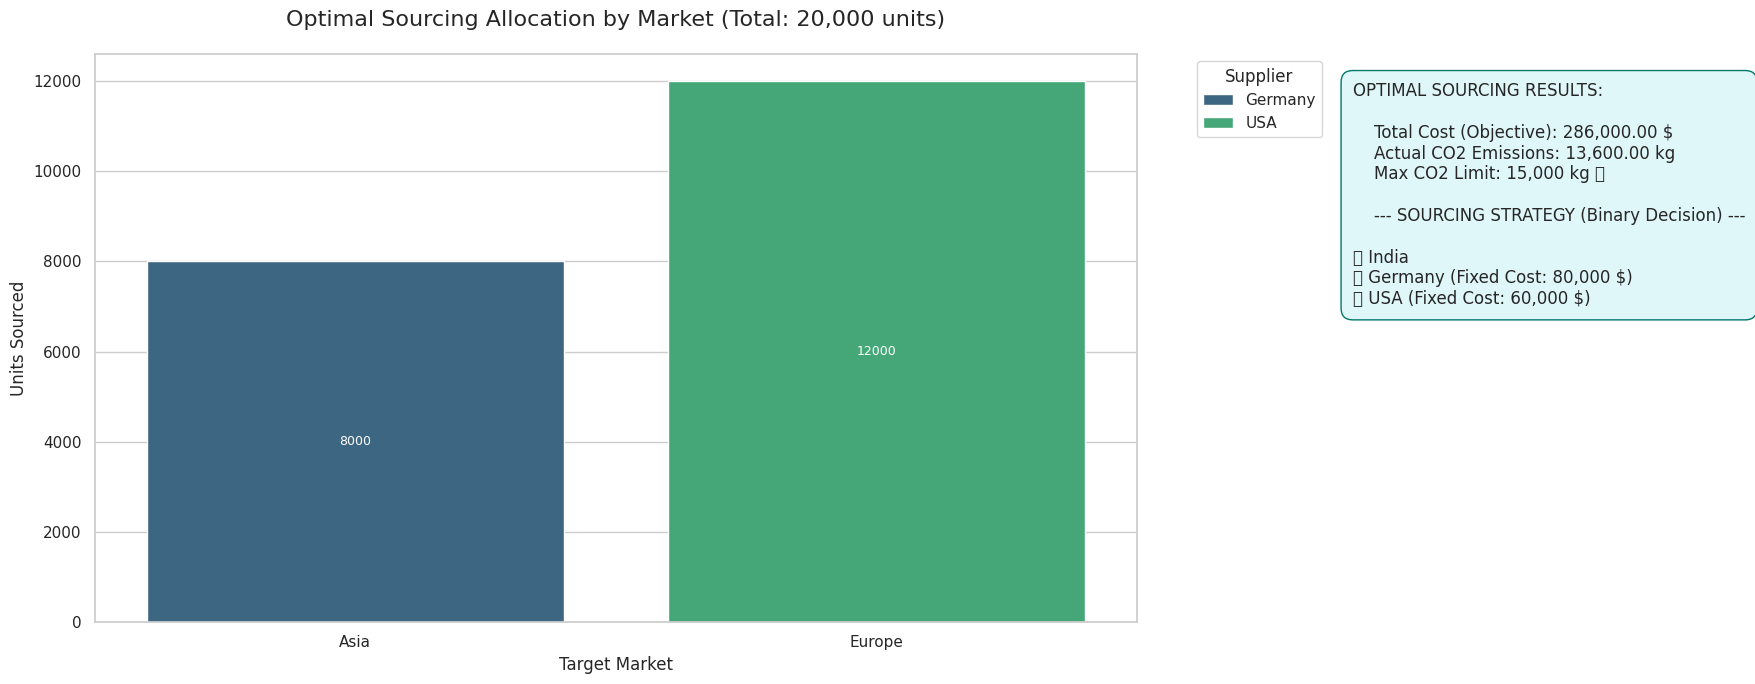

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpStatus, value # Ensure 'value' and 'LpStatus' are imported

# --- 8. DATA PREPARATION FOR VISUALIZATION ---

# Assuming 'model.status' is 1 (Optimal) after execution
if model.status == 1:

    # Retrieve key metrics from the solved model object
    optimal_total_cost = value(model.objective)
    actual_co2_emission = value(total_co2_emission)

    # 8.1. Create a DataFrame for the flow volumes
    flow_data = []
    for s in suppliers: # s for supplier
        for m in markets: # m for market
            quantity = x[s, m].varValue
            if quantity > 0.001:
                # Use English headers for DataFrame
                flow_data.append({'Supplier': s, 'Market': m, 'Units': quantity})

    df_flow = pd.DataFrame(flow_data)

    # Calculate total sourced demand (assuming 'demand' dictionary is available)
    total_units_sourced = sum(demand.values())

    # --- 9. CREATING THE PROFESSIONAL VISUALIZATION ---

    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [3, 1]})

    # Graph 1: Optimal Sourcing Allocation (Stacked Bar Chart)
    if not df_flow.empty:
        sns.barplot(data=df_flow, x='Market', y='Units', hue='Supplier', dodge=False, ax=axes[0], palette='viridis')
        axes[0].set_title(f'Optimal Sourcing Allocation by Market (Total: {total_units_sourced:,.0f} units)', fontsize=16, pad=20)
        axes[0].set_ylabel('Units Sourced', fontsize=12)
        axes[0].set_xlabel('Target Market', fontsize=12)
        axes[0].ticklabel_format(style='plain', axis='y')
        axes[0].legend(title='Supplier', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Add total labels on the bars
        for container in axes[0].containers:
            axes[0].bar_label(container, fmt='%.0f', label_type='center', color='white', fontsize=9)
    else:
        axes[0].text(0.5, 0.5, "No units sourced in this scenario.", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize=12)
        axes[0].set_title('Optimal Sourcing Allocation by Market', fontsize=16, pad=20)


    # Graph 2: Key Metrics Summary (Text Box)
    axes[1].axis('off')

    # Summary based on your successful execution results
    summary_text = f"""
    OPTIMAL SOURCING RESULTS:

    Total Cost (Objective): {optimal_total_cost:,.2f} $
    Actual CO2 Emissions: {actual_co2_emission:,.2f} kg
    Max CO2 Limit: {max_total_co2:,.0f} kg ✅

    --- SOURCING STRATEGY (Binary Decision) ---
    """

    # List of selected suppliers (binary decision 'y')
    for s in suppliers:
        if y[s].varValue > 0.5:
            summary_text += f"\n✅ {s} (Fixed Cost: {fixed_costs[s]:,.0f} $)"
        else:
             summary_text += f"\n❌ {s}"


    # Display the summary box
    axes[1].text(0.05, 0.95, summary_text.strip(),
                 transform=axes[1].transAxes,
                 fontsize=12,
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.7", fc="#e0f7fa", ec="#00796b", lw=1))

    plt.tight_layout()
    plt.show()

else:
    # This message should not appear if your model is Optimal (1)
    print(f"\nVisualization Failed: Model status is {LpStatus[model.status]}.")